In [258]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [257]:
%load_ext autoreload
%autoreload 2 

import os
import sys

curr_dir = os.getcwd()
print('current direcotry is ', curr_dir)
if curr_dir not in sys.path:
    sys.path.append(curr_dir)
src_dir = os.path.join(curr_dir, 'src')
if src_dir not in sys.path:
    sys.path.append(src_dir)
print(sys.path)

#
pdb_dir = '/home/yuan/data/pdb/rsync'
data_dir = './data/'
outputs_dir = '/home/yuan/output/pdb_abag'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
current direcotry is  /home/yuan/bio/protein_design/docking_antigen-antibody/antibody_antigen_complex
['/home/yuan/anaconda3/envs/openfold-env/lib/python310.zip', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/lib-dynload', '', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/site-packages', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/site-packages/openfold-2.2.0-py3.10-linux-x86_64.egg', '/home/yuan/bio/protein_design/docking_antigen-antibody/antibody_antigen_complex', '/home/yuan/bio/protein_design/docking_antigen-antibody/antibody_antigen_complex/src']


In [56]:
# number of all pdb
from src.utils import Utils

raw_pdb_files = Utils.get_raw_pdb(pdb_dir)
print(len(raw_pdb_files))

226302


In [57]:
# number of abag complex 
pdb_ids = {}
for prefix in os.listdir(outputs_dir):
    _path = os.path.join(outputs_dir, prefix)
    if os.path.isdir(_path):
        for _id in os.listdir(_path):
            pdb_ids[_id] = os.path.join(_path, _id)
print(len(pdb_ids))

6197


## uniprot

In [112]:
# test run_meta.py
from src.parse_abag import ParseAbAg
pdb_file = raw_pdb_files['9FGS']
p = ParseAbAg(pdb_file)
print(pdb_file)
# get chains
p.get_chains()
# filter: is antibody-antigen complex
info = p.filter_antibody_antigen(outputs_dir)
# update self.chain from self.info
p.update_chains('chain_type')
p.save_annot()

Successfully retrieve structure of 9FGS
/home/yuan/data/pdb/rsync/fg/pdb9fgs.ent.gz
outputs dir:  /home/yuan/output/pdb_abag/9F/9FGS
https://www.ebi.ac.uk/pdbe/api/mappings/9fgs
Save annotation of 9FGS: /home/yuan/output/pdb_abag/9F/9FGS/meta.json


In [113]:
# test retrieve uniprot data
from src.utils import Utils

for pdb_id in pdb_ids:
    if pdb_id not in ready:
        res = Utils.pdb_to_uniprot(pdb_id)
        pdb_file = pdb_ids[pdb_id]
        print(pdb_id, pdb_file, list(res))
        break

https://www.ebi.ac.uk/pdbe/api/mappings/9fjk
9FJK /home/yuan/output/pdb_abag/9F/9FJK ['UniProt', 'GO', 'InterPro', 'Pfam', 'EC', 'CATH', 'CATH-B', 'SCOP', 'HMMER', 'Ensembl']


In [196]:
# how many pdb with uniprot
from src.utils import Utils

ready = Utils.get_meta(outputs_dir)
print(f"number of AbAg complexes: {len(ready)}")

number of AbAg complexes: 6197


In [437]:
meta_iter = Utils.iter_meta(outputs_dir)
data = []
for pdb_id, meta in meta_iter:
    sub1 = []
    for model in meta['chains']:
        for chain in model['chains']:
            rec = {
                'pdb_id': pdb_id,
                'model_id': model['model_id'],
            }
            rec.update(chain)
            sub1.append(rec)
    sub1 = pd.DataFrame(sub1)
    data.append(sub1)
data = pd.concat(data)
data['chain_type'] = data['chain_type'].map(lambda x: 'single-domain' if x == 'antibody' else x)
data.head()

,pdb_id,model_id,chain_id,AA residues,seq,chain_type
0,9FGS,0,C,191,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,receptor
1,9FGS,0,E,222,VQLLQSAGGLVQPGGSLRLSCAASGLTVSANYMSWVRQAPGKGLEW...,single-domain
0,9FJK,0,A,1040,NLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNV...,receptor
1,9FJK,0,B,1047,NLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNV...,receptor
2,9FJK,0,C,1055,NLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNV...,receptor


In [442]:
Counter([3,4,5,4])

Counter({4: 2, 3: 1, 5: 1})

heavy ...
   res_len  counts
0      221     315
1      120     260
2      218     240
light ...
   res_len  counts
0      107     529
1      213     459
2      214     431
single-domain ...
   res_len  counts
0      232     182
1      233     120
2      231     110


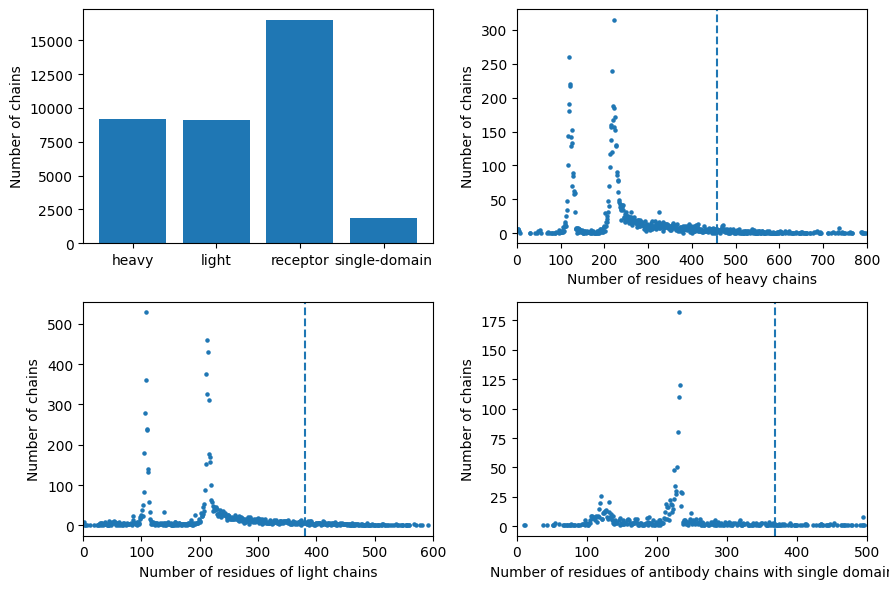

In [451]:
from scipy import stats
from collections import Counter

def count_data(df, chain_type):
    df1 = df[df['chain_type']==chain_type]['AA residues']
    c1 = Counter(df1)
    c1 = sorted(c1.items(), key=lambda x: -x[1])
    print(chain_type, '...')
    c1 = pd.DataFrame(c1, columns=['res_len', 'counts'])
    print(c1.head(3))
    return c1


fig, ax = plt.subplots(2,2, figsize=(9,6), layout='tight')

g = data.groupby('chain_type').agg('count')
i=(0,0)
ax[i].bar(g.index, g['seq'])
ax[i].set_ylabel('Number of chains')

q = .95  # quantile
i=(0,1)
c1 = count_data(data, 'heavy')
ax[i].scatter(c1['res_len'], c1['counts'], s=5)
ax[i].set_xlim(0, 800)
ax[i].set_xlabel('Number of residues of heavy chains')
ax[i].set_ylabel('Number of chains')
ax[i].axvline(np.quantile(df1, q), linestyle='--')

i=(1,0)
c2 = count_data(data, 'light')
ax[i].scatter(c2['res_len'], c2['counts'], s=5)
ax[i].set_xlim(0, 600)
ax[i].set_xlabel('Number of residues of light chains')
ax[i].set_ylabel('Number of chains')
ax[i].axvline(np.quantile(df2, q), linestyle='--')

i=(1,1)
c3 = count_data(data, 'single-domain')
ax[i].scatter(c3['res_len'], c3['counts'], s=5)
ax[i].set_xlim(0, 500)
ax[i].set_xlabel('Number of residues of antibody chains with single domain')
ax[i].set_ylabel('Number of chains')
ax[i].axvline(np.quantile(df3, q), linestyle='--')

## heatmap

In [481]:
from src.utils import Utils
from src.collect import Collect
from src.plot_abag import PlotAbAg

### heavy chain

In [482]:
collector = Collect(outputs_dir, 'heavy-receptor', chain_len = 221)
heavy_sasa, heavy_receptor_sasa = collector.pair_sasa()
heavy_dist, heavy_receptor_dist = collector.pair_dist()

(221, 539) (1853, 539)
(221, 971) (1853, 971)


(421, 221) (421, 221)


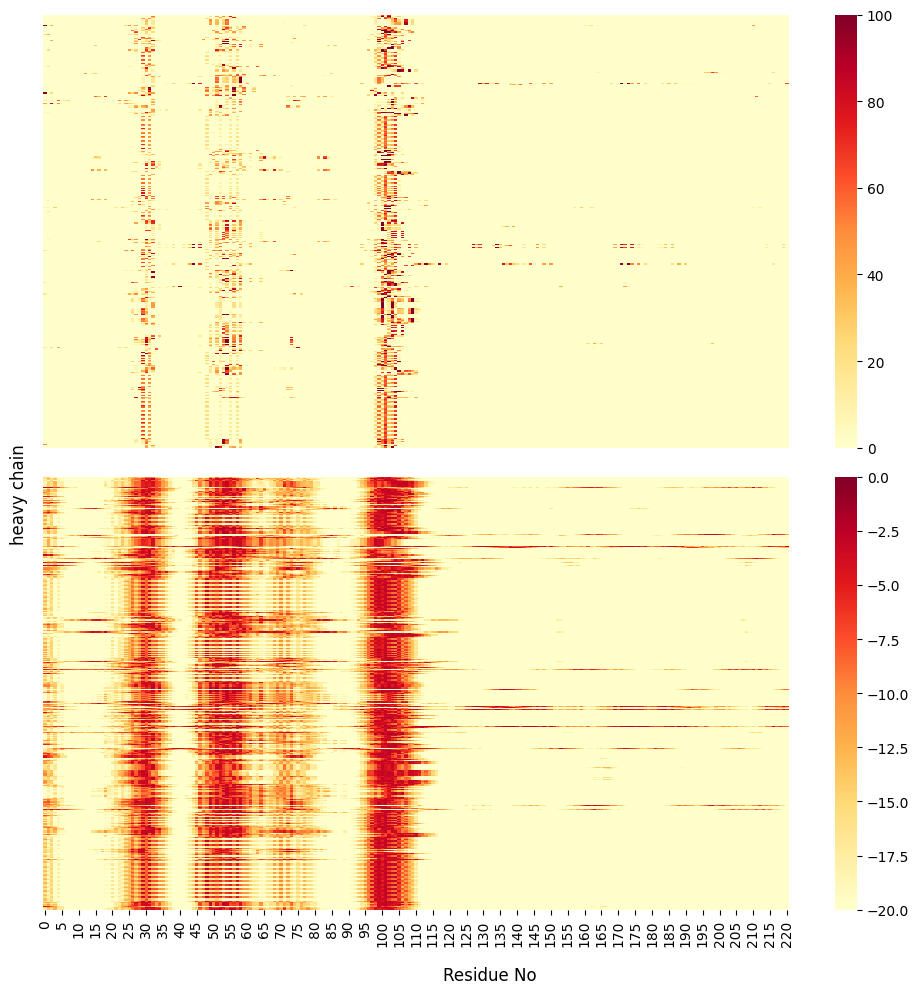

In [483]:
heavy_sasa_match, heavy_dist_match = Utils.match_chains(heavy_sasa, heavy_dist)
PlotAbAg.plot_heatmap(heavy_sasa_match, heavy_dist_match, 'heavy chain')

(421, 1853) (421, 1853)


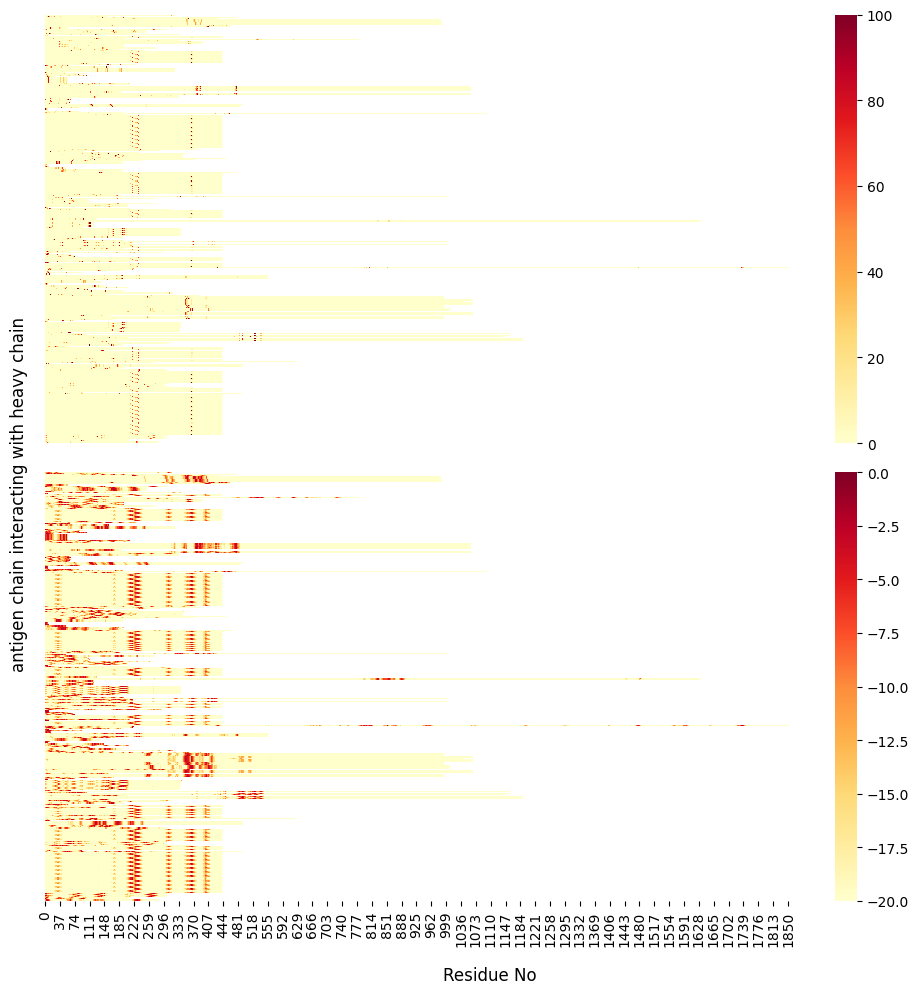

In [484]:
heavy_receptor_sasa_match, heavy_receptor_dist_match = Utils.match_chains(heavy_receptor_sasa, heavy_receptor_dist)
PlotAbAg.plot_heatmap(heavy_receptor_sasa_match, heavy_receptor_dist_match, 'antigen chain interacting with heavy chain')

In [485]:
# another length
collector = Collect(outputs_dir, 'heavy-receptor', chain_len = 120)
heavy_sasa, heavy_receptor_sasa = collector.pair_sasa()
heavy_dist, heavy_receptor_dist = collector.pair_dist()

(120, 342) (1098, 342)
(120, 571) (1098, 571)


(218, 120) (218, 120)


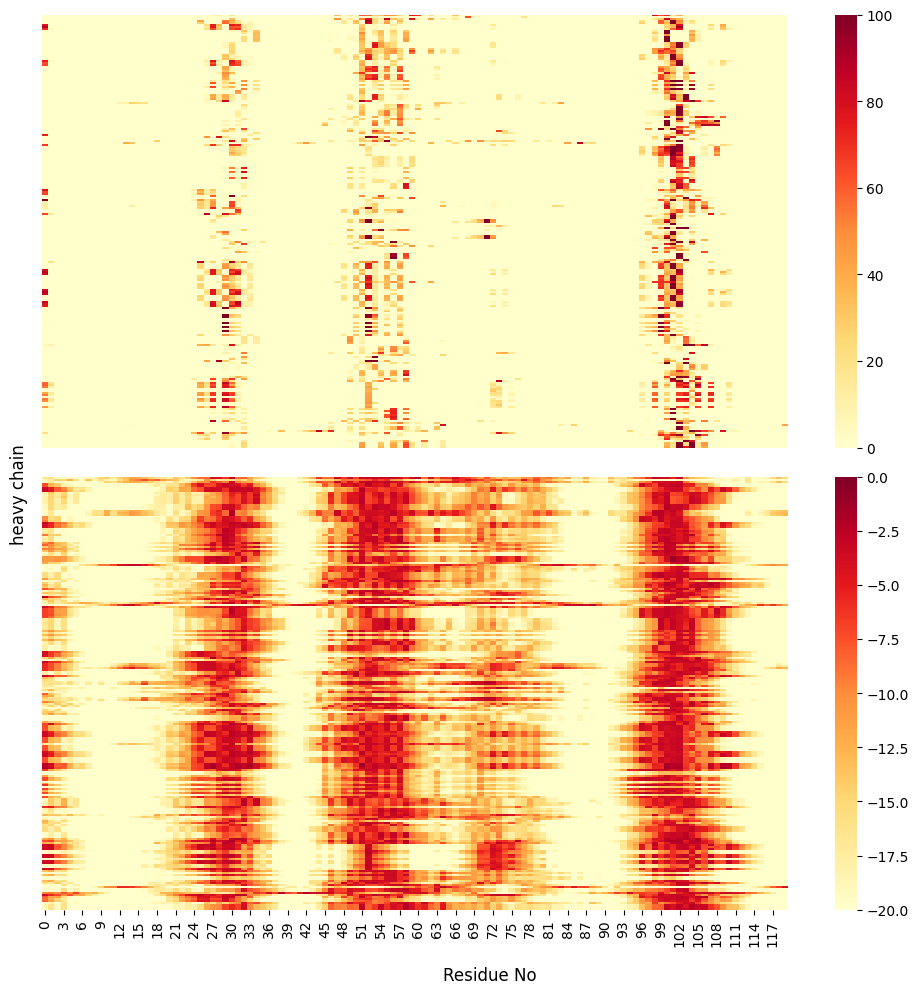

In [486]:
heavy_sasa_match, heavy_dist_match = Utils.match_chains(heavy_sasa, heavy_dist)
PlotAbAg.plot_heatmap(heavy_sasa_match, heavy_dist_match, 'heavy chain')

(218, 1098) (218, 1098)


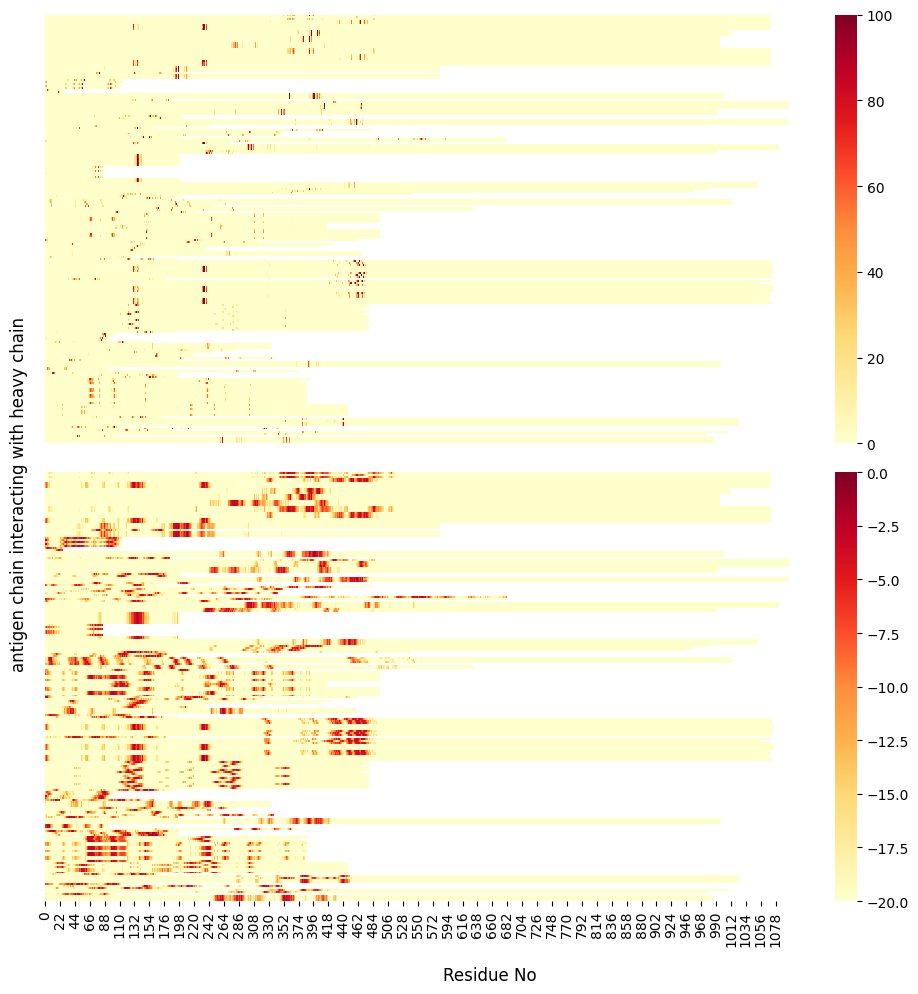

In [487]:
heavy_receptor_sasa_match, heavy_receptor_dist_match = Utils.match_chains(heavy_receptor_sasa, heavy_receptor_dist)
PlotAbAg.plot_heatmap(heavy_receptor_sasa_match, heavy_receptor_dist_match, 'antigen chain interacting with heavy chain')

### light chain

In [488]:
collector = Collect(outputs_dir, 'light-receptor', chain_len = 107)
light_sasa, light_receptor_sasa = collector.pair_sasa()
light_dist, light_receptor_dist = collector.pair_dist()

(107, 582) (1175, 582)
(107, 2492) (1175, 2492)


(511, 107) (511, 107)


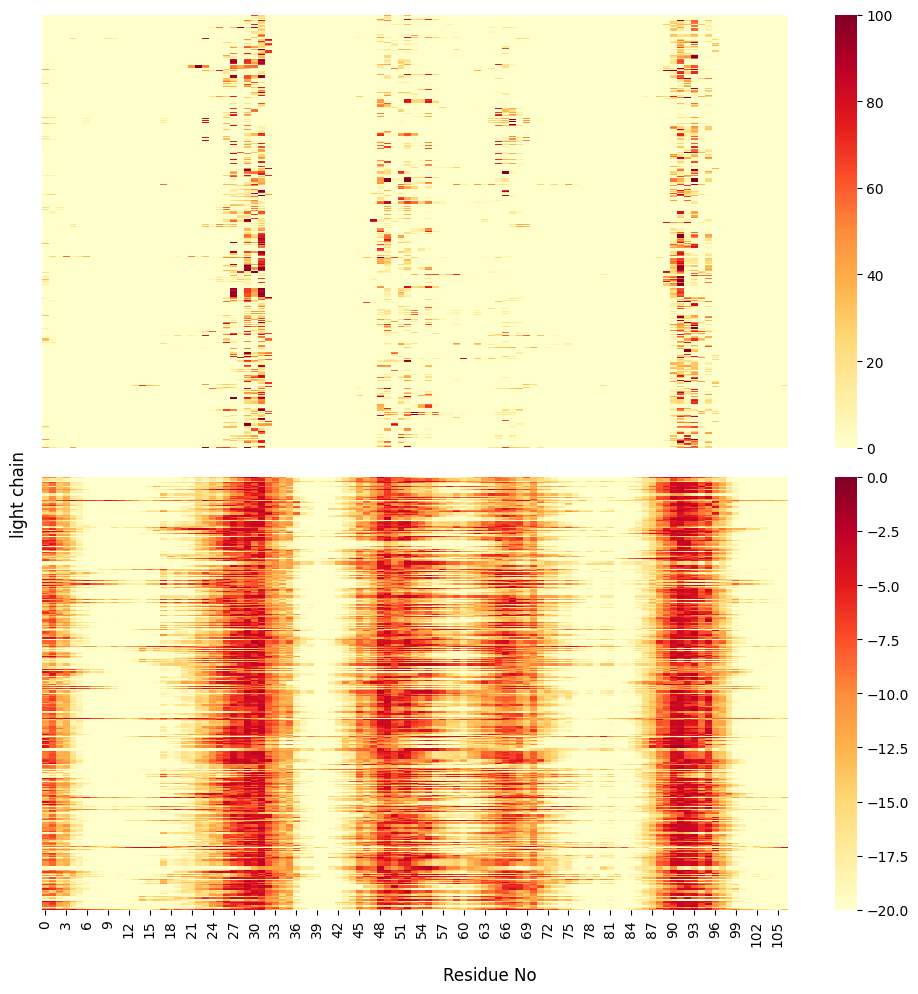

In [489]:
light_sasa_match, light_dist_match = Utils.match_chains(light_sasa, light_dist)
PlotAbAg.plot_heatmap(light_sasa_match, light_dist_match, 'light chain')

(511, 1175) (511, 1175)


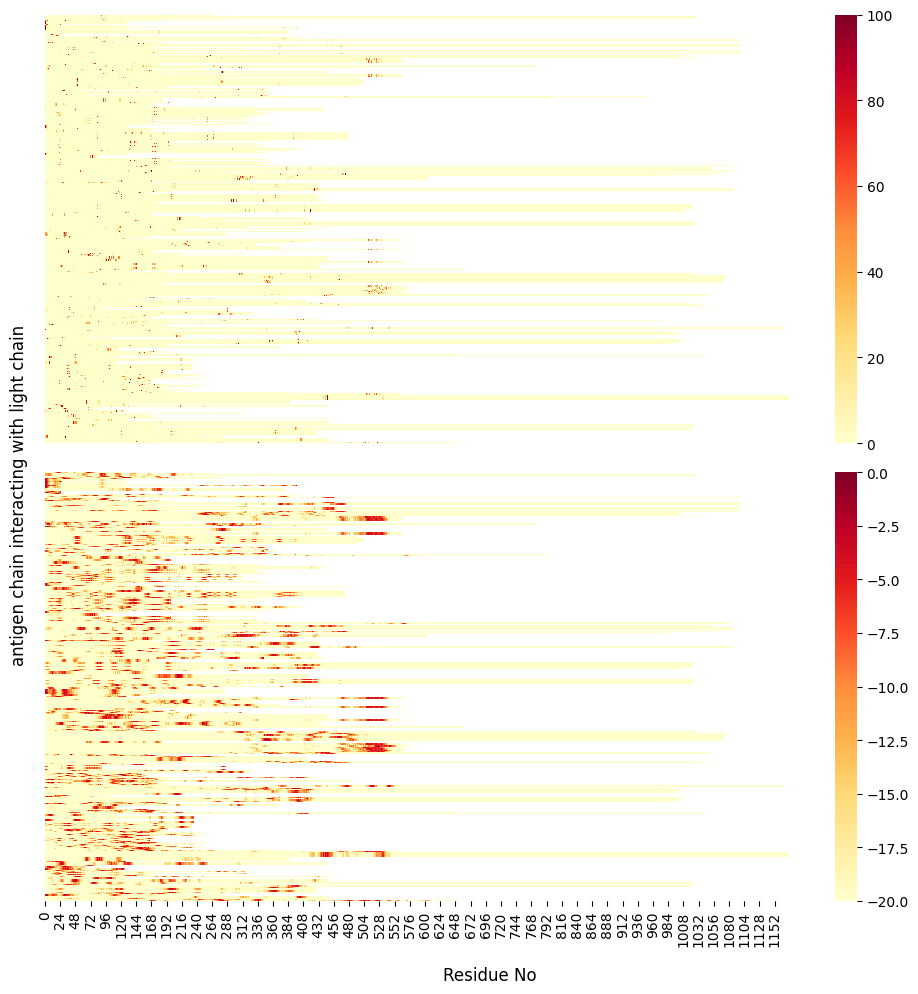

In [490]:
light_receptor_sasa_match, light_receptor_dist_match = Utils.match_chains(light_receptor_sasa, light_receptor_dist)
PlotAbAg.plot_heatmap(light_receptor_sasa_match, light_receptor_dist_match, 'antigen chain interacting with light chain')

In [491]:
collector = Collect(outputs_dir, 'light-receptor', chain_len = 213)
light_sasa, light_receptor_sasa = collector.pair_sasa()
light_dist, light_receptor_dist = collector.pair_dist()

(213, 1027) (1634, 1027)
(213, 3062) (1634, 3062)


(889, 213) (889, 213)


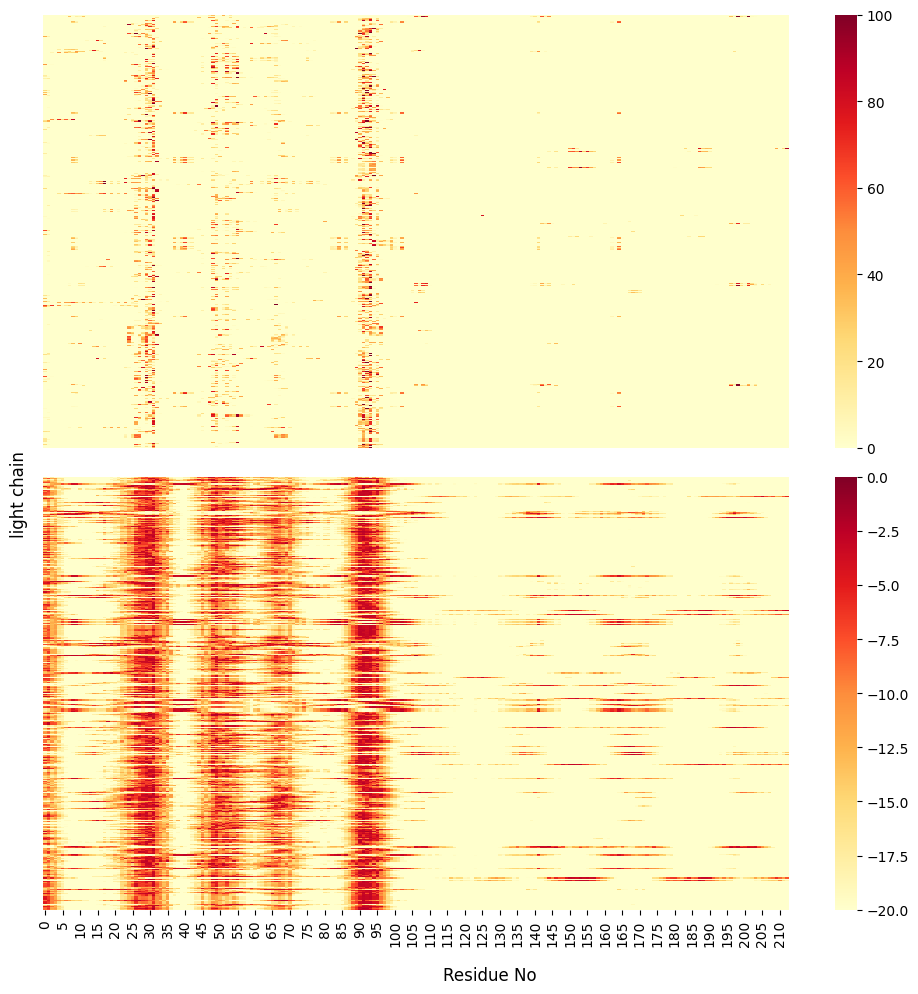

In [492]:
light_sasa_match, light_dist_match = Utils.match_chains(light_sasa, light_dist)
PlotAbAg.plot_heatmap(light_sasa_match, light_dist_match, 'light chain')

(889, 1634) (889, 1634)


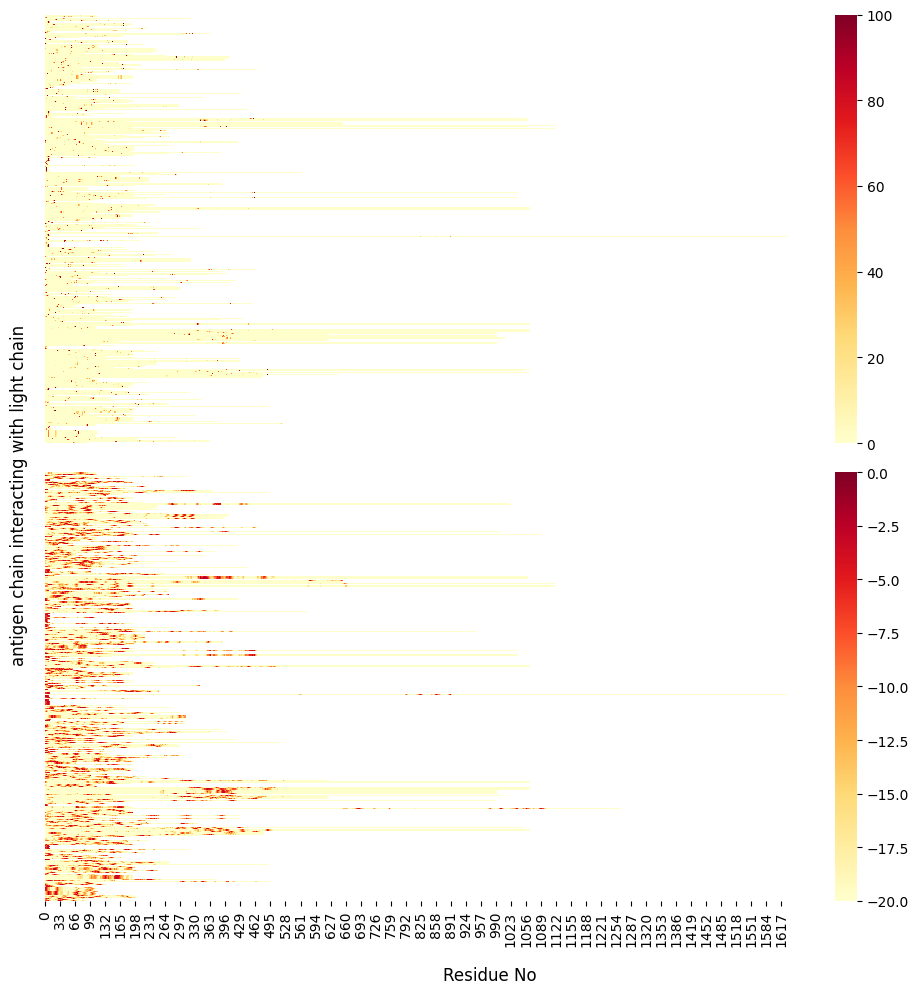

In [493]:
light_receptor_sasa_match, light_receptor_dist_match = Utils.match_chains(light_receptor_sasa, light_receptor_dist)
PlotAbAg.plot_heatmap(light_receptor_sasa_match, light_receptor_dist_match, 'antigen chain interacting with light chain')

### single-domain chain

In [494]:
collector = Collect(outputs_dir, 'antibody-receptor', chain_len = 231)
antibody_sasa, antibody_receptor_sasa = collector.pair_sasa()
antibody_dist, antibody_receptor_dist = collector.pair_dist()

(231, 202) (495, 202)
(231, 476) (973, 476)


(202, 231) (202, 231)


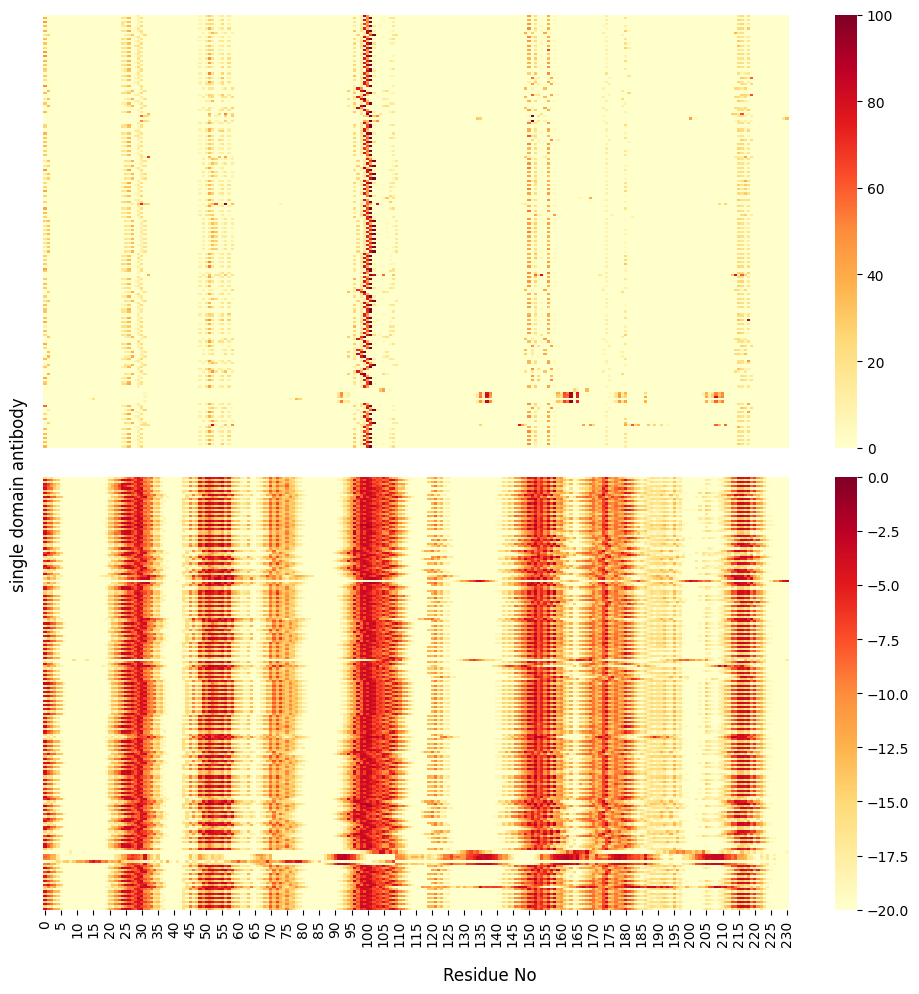

In [495]:
antibody_sasa_match, antibody_dist_match = Utils.match_chains(antibody_sasa, antibody_dist)
PlotAbAg.plot_heatmap(antibody_sasa_match, antibody_dist_match, 'single domain antibody')

(202, 495) (202, 973)


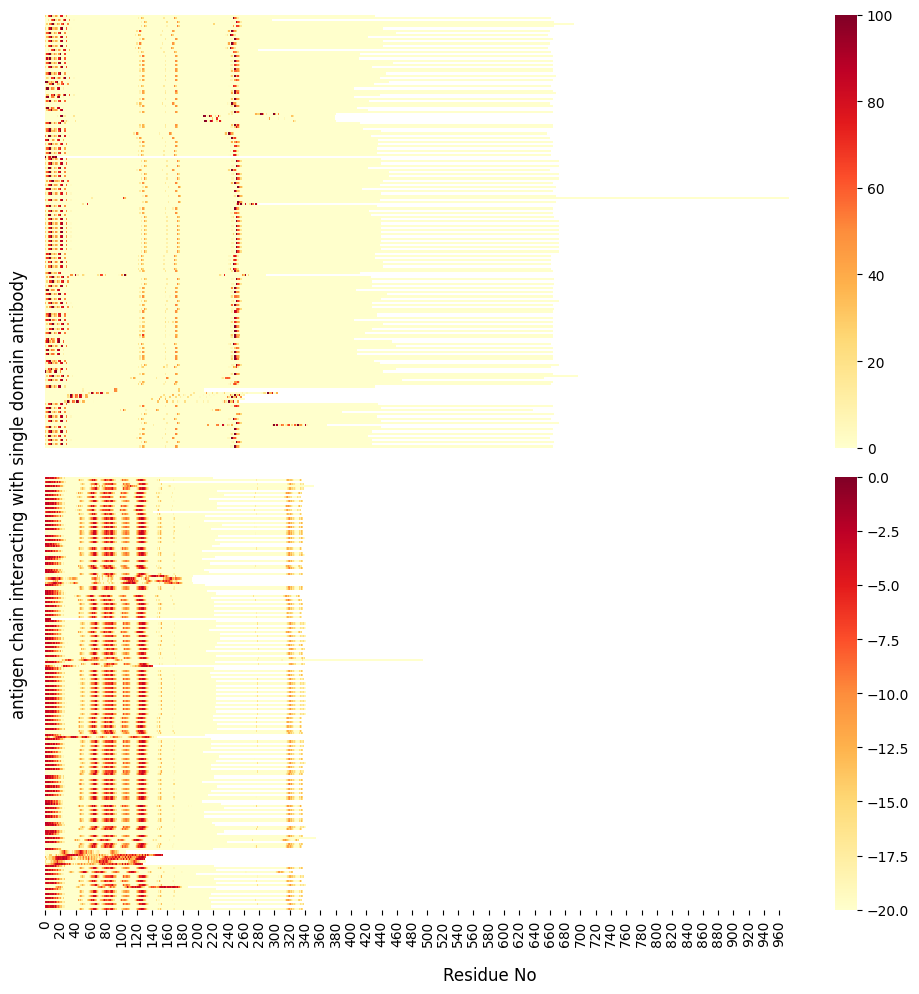

In [496]:
antibody_receptor_sasa_match, antibody_receptor_dist_match = Utils.match_chains(antibody_receptor_sasa, antibody_receptor_dist)
PlotAbAg.plot_heatmap(antibody_receptor_sasa_match, antibody_receptor_dist_match, 'antigen chain interacting with single domain antibody')

In [497]:
collector = Collect(outputs_dir, 'antibody-receptor', chain_len = 232)
antibody_sasa, antibody_receptor_sasa = collector.pair_sasa()
antibody_dist, antibody_receptor_dist = collector.pair_dist()

(232, 356) (1025, 356)
(232, 765) (816, 765)


(352, 232) (352, 232)


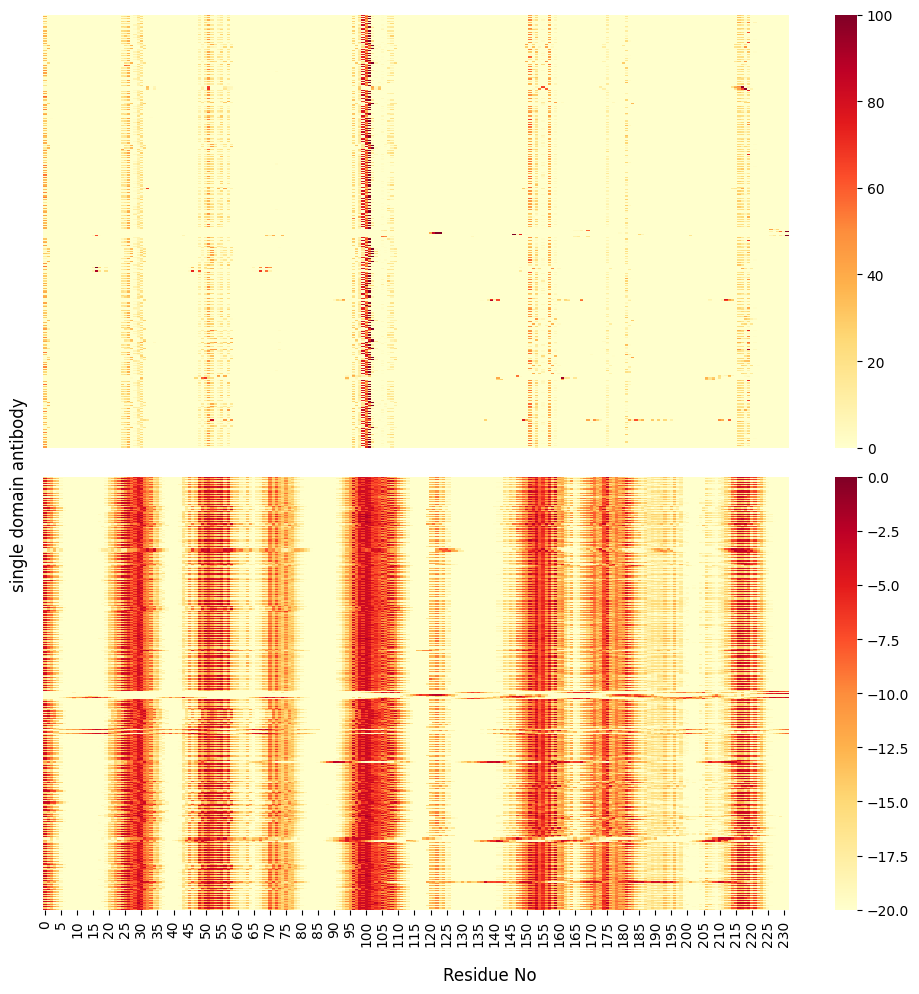

In [498]:
antibody_sasa_match, antibody_dist_match = Utils.match_chains(antibody_sasa, antibody_dist)
PlotAbAg.plot_heatmap(antibody_sasa_match, antibody_dist_match, 'single domain antibody')

(352, 1025) (352, 816)


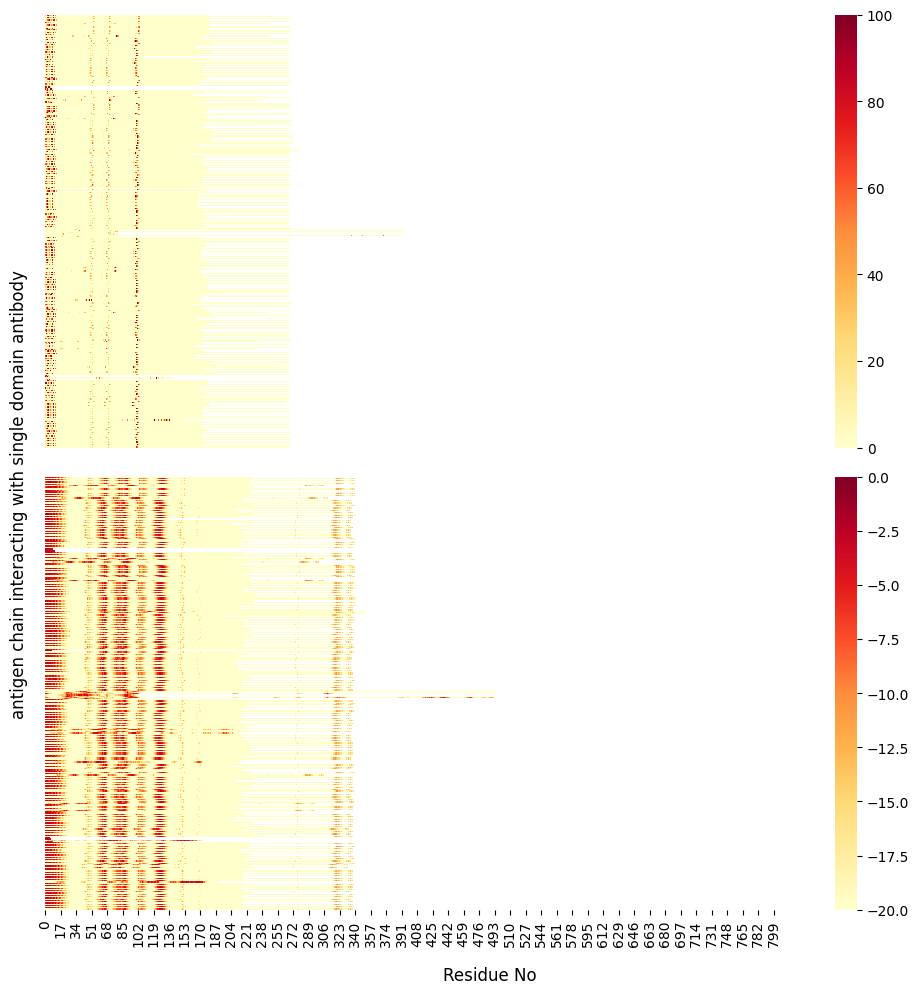

In [499]:
antibody_receptor_sasa_match, antibody_receptor_dist_match = Utils.match_chains(antibody_receptor_sasa, antibody_receptor_dist)
PlotAbAg.plot_heatmap(antibody_receptor_sasa_match, antibody_receptor_dist_match, 'antigen chain interacting with single domain antibody')

In [500]:
collector = Collect(outputs_dir, 'antibody-receptor', chain_len = 233)
antibody_sasa, antibody_receptor_sasa = collector.pair_sasa()
antibody_dist, antibody_receptor_dist = collector.pair_dist()

(233, 209) (921, 209)
(233, 469) (921, 469)


(209, 233) (209, 233)


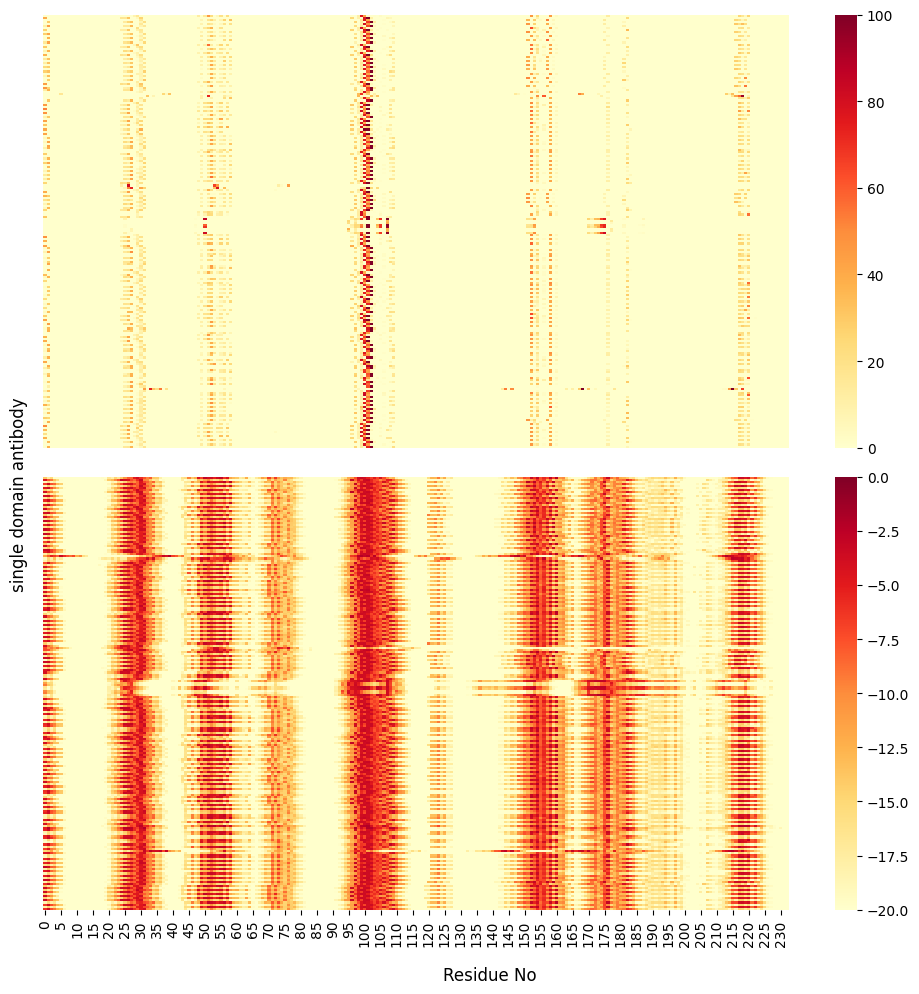

In [501]:
antibody_sasa_match, antibody_dist_match = Utils.match_chains(antibody_sasa, antibody_dist)
PlotAbAg.plot_heatmap(antibody_sasa_match, antibody_dist_match, 'single domain antibody')

(209, 921) (209, 921)


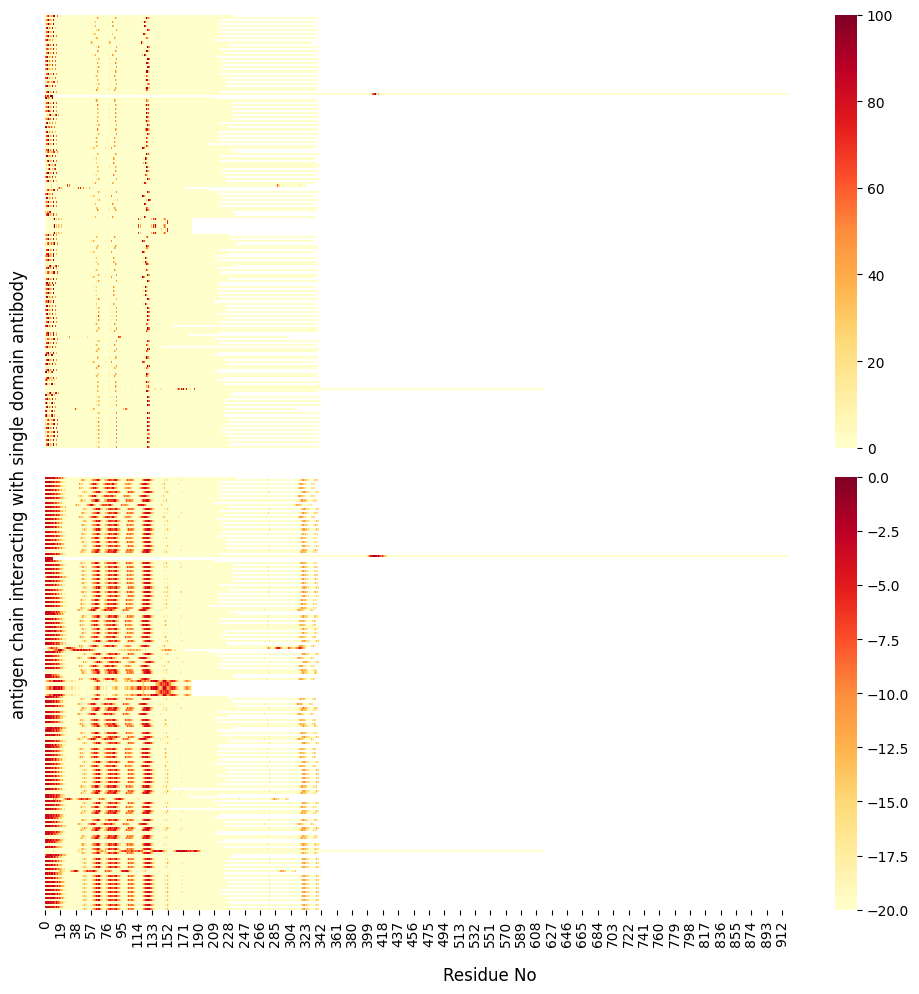

In [502]:
antibody_receptor_sasa_match, antibody_receptor_dist_match = Utils.match_chains(antibody_receptor_sasa, antibody_receptor_dist)
PlotAbAg.plot_heatmap(antibody_receptor_sasa_match, antibody_receptor_dist_match, 'antigen chain interacting with single domain antibody')

### all receptor

In [521]:
# trim chains by chain_len
collector = Collect(outputs_dir, chain_len=1000)
receptor_sasa = collector.receptor_sasa()
receptor_dist = collector.receptor_dist()
receptor_sasa_match, receptor_dist_match = Utils.match_chains(receptor_sasa, receptor_dist)

(1000, 23390)
(1000, 66526)
(23390, 1000) (23390, 1000)


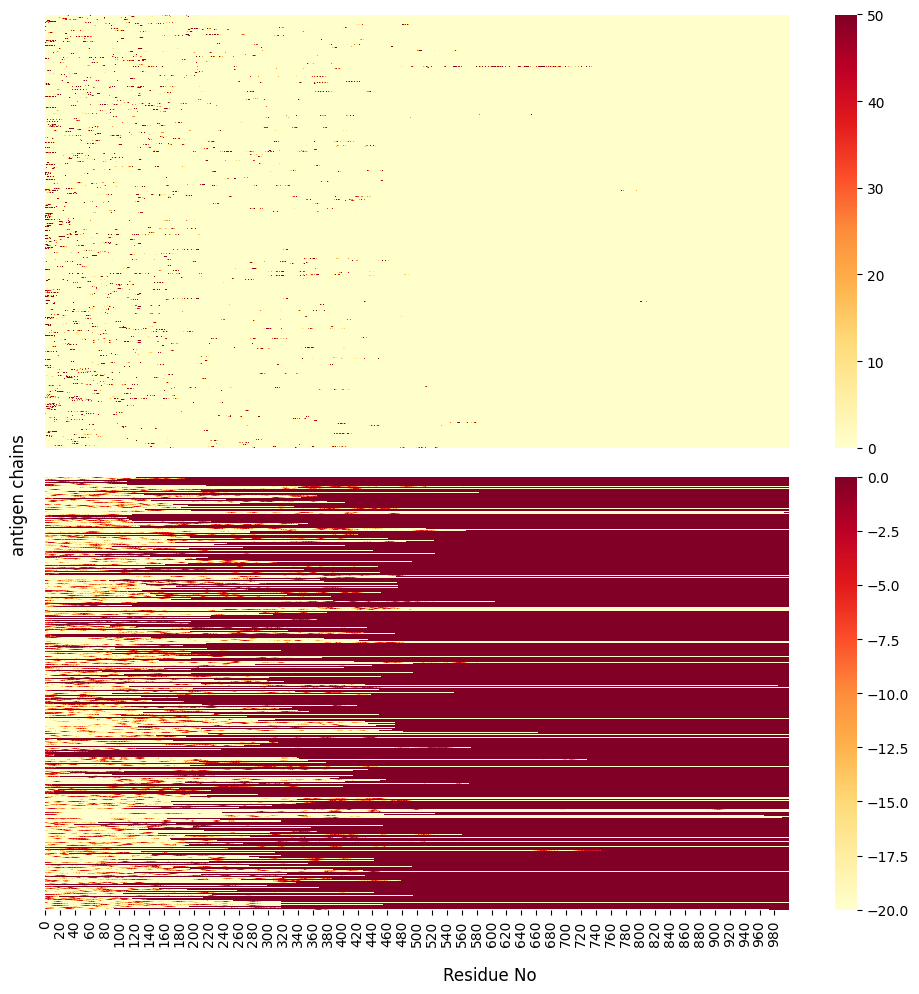

In [523]:
PlotAbAg.plot_heatmap(receptor_sasa_match, receptor_dist_match, 'antigen chains')

In [ ]:
    sub2 = []
    for uniprot_id in meta['UniProt']:
        for mapping in meta['UniProt'][uniprot_id]['mappings']:
            res = {
                'uniprot_acc': uniprot_id,
                'chain_id': mapping['chain_id'],
                'residue_start': mapping['start']['residue_number'],
                'residue_end': mapping['end']['residue_number'],
            }
            sub2.append(res)
    sub2 =pd.DataFrame(sub2)
    sub2
    df1 = pd.merge(sub1, sub2, on='chain_id', how='outer')